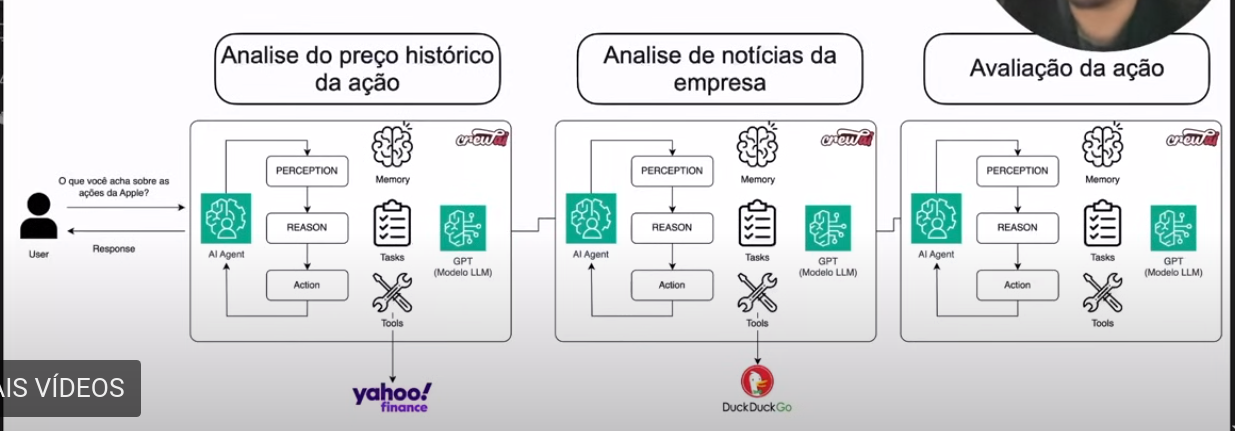

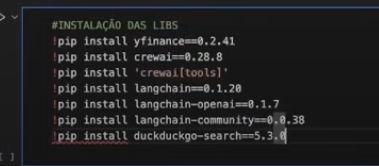

In [1]:
# Instalação das Libs
!pip install yfinance
!pip install crewai
!pip install 'crewai[tools]'
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install numpy==1.24.0
!pip install duckduckgo-search==5.3.0


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 8.6 MB/s eta 0:00:000m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB

In [17]:
import json
import os
from datetime import datetime

import yfinance as yf

from crewai import Agent, Task, Crew, Process

from langchain.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchResults

from IPython.display import Markdown


In [4]:
#Criando Yahoo Finance Tool
def fetch_stock_price(ticket):
    stock = yf.download(ticket, start="2023-08-08", end="2024-08-08")
    return stock

yahoo_finance_tool = Tool(
    name = "Yahoo Finance Tool",
    description = "Fetches stocks prices for {ticket} from the last year about a specific stock from Yahoo Finance API",
    func=  lambda ticket: fetch_stock_price(ticket)
)

In [5]:
response = yahoo_finance_tool.run("AAPL")

[*********************100%%**********************]  1 of 1 completed


In [6]:
print(response)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-08  179.690002  180.270004  177.580002  179.800003  178.643387   
2023-08-09  180.869995  180.929993  177.009995  178.190002  177.043747   
2023-08-10  179.479996  180.750000  177.600006  177.970001  176.825165   
2023-08-11  177.320007  178.619995  176.550003  177.789993  176.884872   
2023-08-14  177.970001  179.690002  177.309998  179.460007  178.546371   
...                ...         ...         ...         ...         ...   
2024-08-01  224.369995  224.479996  217.020004  218.360001  218.107544   
2024-08-02  219.149994  225.600006  217.710007  219.860001  219.605804   
2024-08-05  199.089996  213.500000  196.000000  209.270004  209.028061   
2024-08-06  205.300003  209.990005  201.070007  207.229996  206.990402   
2024-08-07  206.899994  213.639999  206.389999  209.820007  209.577423   

               Volume  
Date         

In [ ]:
# Importando OpenAI LLM - GPT
os.environ['OPENAI_API_KEY'] = "Api key"
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [ ]:
stockPriceAnalyst = Agent(
    role= "Senior stock price Analyst",
    goal="Find the {ticket} stock price and analyses trends",
    backstory="""You´re a highly experienced in analyzing the price of an specific stock
    and make predictions about its future price""",
    verbose=True,
    llm= llm,
    max_inter=5,
    memory= True,
    tools=[yahoo_finance_tool],
    allow_delegation=False
)

In [ ]:
getStockPrice = Task(
    description= "Analyze the stock {ticket} price history and create a trend analyses of up, down or sideways",
    expected_output = """ Specify the current trend stock price - up, down or sideways.
    eg. stock= 'APPL, price UP'
""",
    agent= stockPriceAnalyst
)

In [ ]:
# Importando a Tool de Search
search_tool = DuckDuckGoSearchResults(backend='news', num_results=10)

In [ ]:
newsAnalyst = Agent(
    role= "Stock News Analyst",
    goal="""Create a short summary of the market news related to the stock {ticket} company. Specity the current trend - up, down or sideways
    with the news context. For each request stock asset, specify a number between 0 and 100, when 0 is extreme fear and 100 is extreme greed
    """,
    backstory="""You´re a highly experienced in analyzing the market trends and news and have tracked assest for more then 10years.

    You're also master level analyst in the tradicional markets and have deep understanding o human psychology.

    You understand news, theirs titles and information, but you look at those with a health dose of skepticism. You consider also the source 
    of the news articles.
    """,
    verbose=True,
    llm= llm,
    max_inter=10,
    memory= True,
    tools=[search_tool],
    allow_delegation=False
)

In [ ]:
get_news = Task(
    description= """""Take the stock and always include BTC to it (if not request)
    Use the search tool to search each one individually.

    The current date is {datetime.now()}.

    Compose the results into a helpfull report
    """,
    expected_output = """  A summary of the overall market and one sentence summary for each request asset.
    Include a fear/greed score for each asset based on the news. Use formet:
    <STOCK ASSET>
    <SUMMARY BASED ON NEWS>
    <TREND PREDICTION>
    <FEAR/GREED SCORE>
""",
    agent= newsAnalyst 
)

In [ ]:
stockAnalystWrite = Agent(
    role= "Senior Stock Analyst",
    goal="""Analyze the trends price and news and Write an insighfull compelling and informative 3 paragraph long newsletter based on the stock report and price trend.
    """,
    backstory="""You´re a widely accepted as the best stock analyst in the market. You understand complex concepts and create compelling stories
    and narratives that resonate with wider audiences.

    You understand macro factors and combine multiple theories - eg. cycle theory and fundamental analyses.
    You're able to hold multiple opinions when analyzing anything.

    """,
    verbose=True,
    llm= llm,
    max_inter=5,
    memory= True,
    tools=[search_tool],
    allow_delegation=True
)

In [ ]:
writeAnalyses = Task(
    description= """Use the stock price trend and the stock news report to create an analyses and write the newsletter about the {ticket} company
    that is brief and highlights the most important points.
    Focus on the stock price trend, news and fear/greed score. What are the near future considerations?
    Include the previous analyses of stock trend and news summary
""",
    expected_output = """ An eloquent 3 paragraphs newsletter formated as markdown in an easy readable manner. It should contain:

    - 3 bullets executive summary
    - Introduction - set the overall picture and spike up the interest
    - main part provides the meat of the analysis including the news summary and fear/greed scores
    - summary - key facts and concrete future trend prediction - up, down ou sideways.
""",
    agent= stockAnalystWrite,
    context = [getStockPrice, get_news] 
)

In [ ]:
crew = Crew(
    agents = [stockPriceAnalyst, newsAnalyst, stockAnalystWrite],
    tasks = [getStockPrice, get_news, writeAnalyses],
    verbose = 2,
    process = Process.hierarchical ,
    full_output=True,
    share_crew=False,
    manager_llm=llm,
    max_iter=15
)

In [ ]:
results= crew.kickoff(inputs={'ticket': 'AAPL'})

In [ ]:
list(results.keys())

In [ ]:
results['final_output']

In [ ]:
len(results['tasks_outputs'])

Markdown(results['final_output'])